In [1]:
# Import libraries 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
import glob 
from timezonefinder import TimezoneFinder

# Plotting utils 
import matplotlib.pyplot as plt 
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Read in data

In [2]:
## Set up case directories for two CTSM/CLM cases and get list of all files:
## ------------------------------------------------------------------------

# Define directory where files are saved (usually on /glade/scratch)
# dataDir = '/glade/scratch/oleson/archive/'
dataDir = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/tempDir/'


# Define two casenames to compare 
case1 = 'cam6clm50sp_cesm23a02cPPEn08ctsm51d030_1deg_hist'
case2 = 'cam6ctsm51sp_cesm23a02cPPEn08ctsm51d030_1deg_hist'

# Define which history files the necessary *hourly* atm variables are saved in
histFileNum_cam = '6'

# Get list of files to read data for 
#   NOTE: This section should be modified to use a start year and end year 
#         rather than a hard coded 198*
# ATMfiles_case1 = sorted(glob.glob(dataDir+case1+'/atm/hist/'+case1+'.cam.h'+histFileNum_cam+'.198*'))
# ATMfiles_case2 = sorted(glob.glob(dataDir+case2+'/atm/hist/'+case2+'.cam.h'+histFileNum_cam+'.198*'))
ATMfiles_case1 = sorted(glob.glob(dataDir+case1+'.cam.h'+histFileNum_cam+'.198*'))
ATMfiles_case2 = sorted(glob.glob(dataDir+case2+'.cam.h'+histFileNum_cam+'.198*'))


# Open a test file first to get lat/lon and resolution of model grid
with xr.open_dataset(ATMfiles_case1[0]) as testDS:
    latCESM = testDS.lat.values
    lonCESM = testDS.lon.values

# Get model resolution for gridcell spacing 
modelRes_lat = latCESM[1]-latCESM[0]
modelRes_lon = lonCESM[1]-lonCESM[0]



In [3]:
## Now get the latitude and longitude of desired station points from text file: 
## ---------------------------------------------------------------------

# Read in lines from text file
RUBISCO_filePath = '/Users/mdfowler/Desktop/beta3sites.txt'
with open(RUBISCO_filePath) as f:
    StationLines = f.readlines()

# Now pull out the lat/lon of each station (each station has its own line)
#    We also happen to know in advance that the 4th and 5th entries are longitude and latitude, respectively. 
nStations   = len(StationLines) 
lonStations = np.full([nStations], np.nan)
latStations = np.full([nStations], np.nan)
stationNames = np.empty([nStations]).astype(str)

lonStations_CESM = np.full([nStations], np.nan)
latStations_CESM = np.full([nStations], np.nan)
    
for iStation in range(nStations):
    lonStations[iStation] = StationLines[iStation].split(',')[3]
    latStations[iStation] = StationLines[iStation].split(',')[4]
    stationNames[iStation] = StationLines[iStation].split(',')[0]
    
    # Longitude recorded in RUBISCO coordinates is -180 to 180, but model output is 0-360. 
    #   So convert station lons: 
    lonStations_360 = (lonStations[iStation] + 360.0) % 360.0
    
    # Get index of lat/lon in model containing the station
    latStations_CESM[iStation] = np.where( (latCESM>=latStations[iStation]-(modelRes_lat/2)) & (latCESM<=latStations[iStation]+(modelRes_lat/2)))[0]
    lonStations_CESM[iStation] = np.where( (lonCESM>=lonStations_360-(modelRes_lon/2))       & (lonCESM<=lonStations_360+(modelRes_lon/2))) [0]
    

In [4]:
ATM_case1_DS = xr.open_mfdataset(
        ATMfiles_case1,
        # Name of the dimension to concatenate along.
        concat_dim="time",

        # Attempt to auto-magically combine the given datasets into one by using dimension coordinates.
        combine="by_coords",

        # Specify chunks for dask - explained later
        chunks={"lev": 1, "time": 500},

        # Only data variables in which the dimension already appears are included.
        data_vars="minimal",

        # Only coordinates in which the dimension already appears are included.
        coords="minimal",

        # Skip comparing and pick variable from first dataset.
        compat="override",
        parallel=True,
    )

# Select just the points that correspond to the stations 
ATM_case1_DS = ATM_case1_DS.isel(lat=latStations_CESM.astype(int), lon=lonStations_CESM.astype(int))

# Convert time index to datetime 
ATM_case1_DS['time']  = ATM_case1_DS.indexes['time'].to_datetimeindex()


/Users/mdfowler/opt/anaconda3/envs/lens-py/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


In [5]:
ATM_case2_DS = xr.open_mfdataset(
        ATMfiles_case2,
        # Name of the dimension to concatenate along.
        concat_dim="time",

        # Attempt to auto-magically combine the given datasets into one by using dimension coordinates.
        combine="by_coords",

        # Specify chunks for dask - explained later
        chunks={"lev": 1, "time": 500},

        # Only data variables in which the dimension already appears are included.
        data_vars="minimal",

        # Only coordinates in which the dimension already appears are included.
        coords="minimal",

        # Skip comparing and pick variable from first dataset.
        compat="override",
        parallel=True,
    )

# Select just the points that correspond to the stations 
ATM_case2_DS = ATM_case2_DS.isel(lat=latStations_CESM.astype(int), lon=lonStations_CESM.astype(int))

# Convert time index to datetime 
ATM_case2_DS['time']  = ATM_case2_DS.indexes['time'].to_datetimeindex()


/Users/mdfowler/opt/anaconda3/envs/lens-py/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


In [6]:
## Get local times at each station:
## !! Note: It's assumed that the times are the same in both cases - may need to edit this if not !! 
## ---------------------------------

# Convert times to a pandas datetime array, with UTC timezone
times_CESM = pd.DatetimeIndex(ATM_case2_DS.time.values, tz='UTC')

timesLocal = np.copy(times_CESM)
timesLocal = np.expand_dims(timesLocal, axis=0)

for iStation in range(nStations):
    # Get string of time zone for station 
    tf           = TimezoneFinder()
    timezone_str = tf.timezone_at(lng=lonStations[iStation], lat=latStations[iStation]) 
    
    # Convert station time from UTC to local
    timesLocal_temp = times_CESM.tz_convert(tz=timezone_str)
    
    if iStation==0:
        timesLocal[0,:] = timesLocal_temp
    else: 
        timesLocal = np.append(timesLocal, np.expand_dims(timesLocal_temp, axis=0), axis=0)

# Add local time as a variable to the full xr datasets 
ATM_case1_DS['LocalTime'] = (('lat','time'), timesLocal)        
ATM_case2_DS['LocalTime'] = (('lat','time'), timesLocal)            


In [8]:
# Stop using dask now 
ATM_case1_DS = ATM_case1_DS.compute()               # continue on with Pandas/NumPy
ATM_case2_DS = ATM_case2_DS.compute()               # continue on with Pandas/NumPy


## Now do some plotting

In [9]:
#   Let's start with monthly means of each hour per station 
#   Source: https://stackoverflow.com/questions/53970885/xarray-get-hourly-means-for-each-month-in-a-dataset-without-manual-looping

for iStation in range(nStations):
    # First pick out just this station 
    stationDS_case1 = ATM_case1_DS.isel(lat=iStation,lon=iStation)
    stationDS_case2 = ATM_case2_DS.isel(lat=iStation,lon=iStation)
    
    # Now make a new multiIndex that combines month and hour so we can get the mean that way
    stationDS_case1.coords['monthhour'] = (
            ('time', ),
            pd.MultiIndex.from_arrays([pd.DatetimeIndex(stationDS_case1.LocalTime).month, 
                                       pd.DatetimeIndex(stationDS_case1.LocalTime).hour]))
    
    stationDS_case2.coords['monthhour'] = (
            ('time', ),
            pd.MultiIndex.from_arrays([pd.DatetimeIndex(stationDS_case2.LocalTime).month, 
                                       pd.DatetimeIndex(stationDS_case2.LocalTime).hour]))

    # Get the mean for each hour per month, and then unstack the indices accordingly 
    stationDS_case1 = stationDS_case1.groupby('monthhour').mean(dim='time')
    stationDS_case1 = stationDS_case1.unstack('monthhour')
    
    stationDS_case2 = stationDS_case2.groupby('monthhour').mean(dim='time')
    stationDS_case2 = stationDS_case2.unstack('monthhour')
    
    # Just save 7a - 7p
    iselHours       = np.where( (stationDS_case1.monthhour_level_1.values>=7) & (stationDS_case1.monthhour_level_1.values<=19) )[0] 
    stationDS_case1 = stationDS_case1.isel(monthhour_level_1=iselHours)
    
    iselHours       = np.where( (stationDS_case2.monthhour_level_1.values>=7) & (stationDS_case2.monthhour_level_1.values<=19) )[0]
    stationDS_case2 = stationDS_case2.isel(monthhour_level_1=iselHours)
    
    # Add a dimension to represent each station 
    stationDS_case1 = stationDS_case1.expand_dims({"Station": 1})
    stationDS_case2 = stationDS_case2.expand_dims({"Station": 1})
    
    if iStation==0:
        stationDS_full_case1 = stationDS_case1
        stationDS_full_case2 = stationDS_case2
    elif iStation>0: 
        stationDS_full_case1 = xr.concat([stationDS_full_case1, stationDS_case1], "Station")
        stationDS_full_case2 = xr.concat([stationDS_full_case2, stationDS_case2], "Station")
    

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


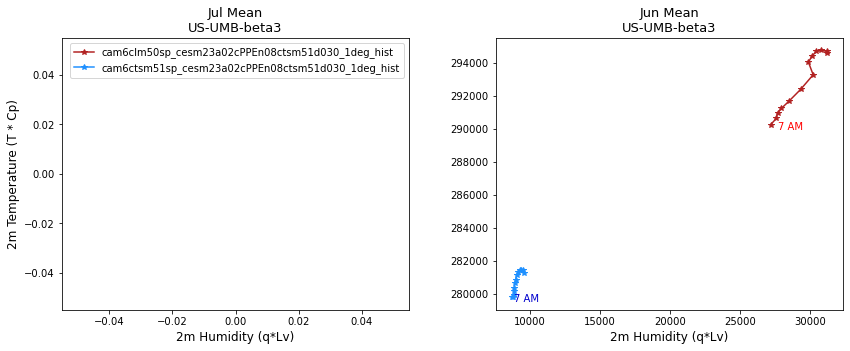

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


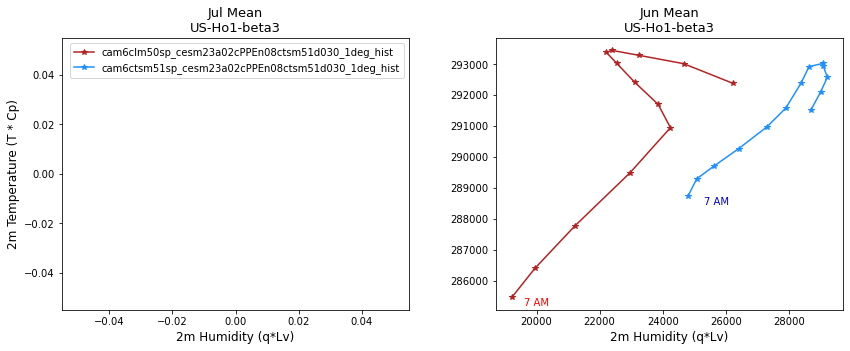

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


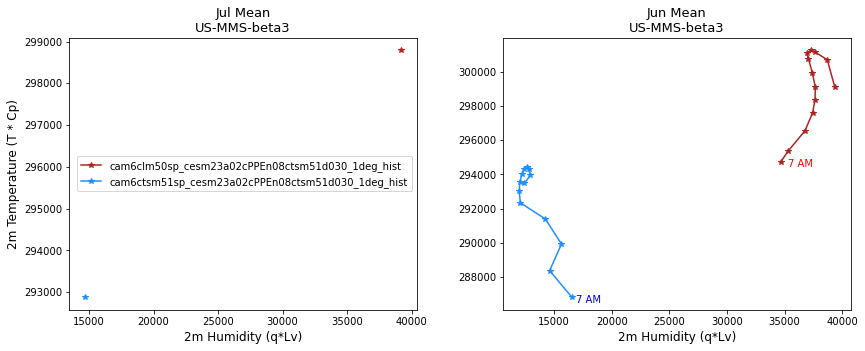

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


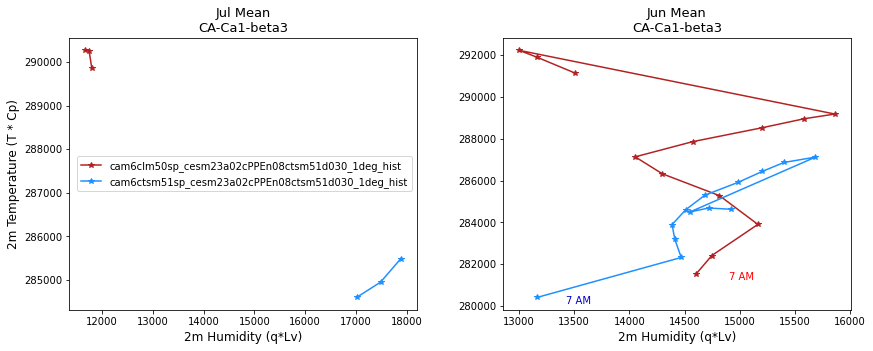

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


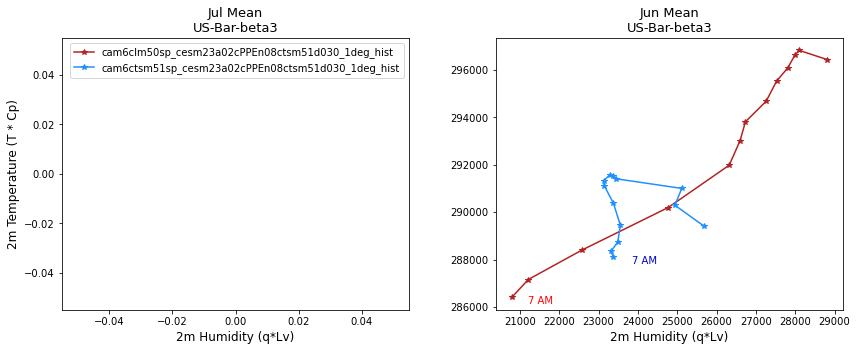

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


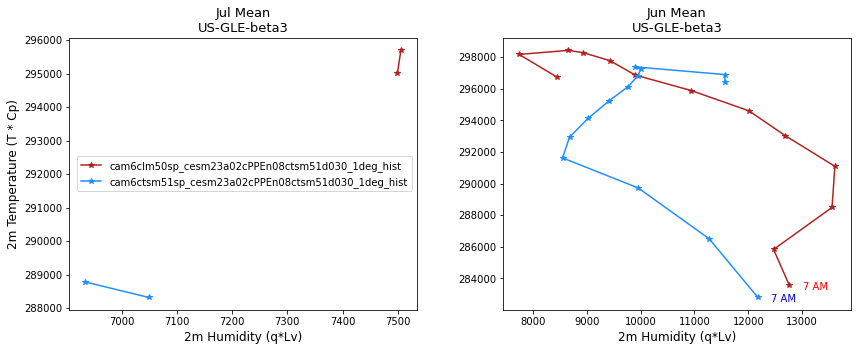

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


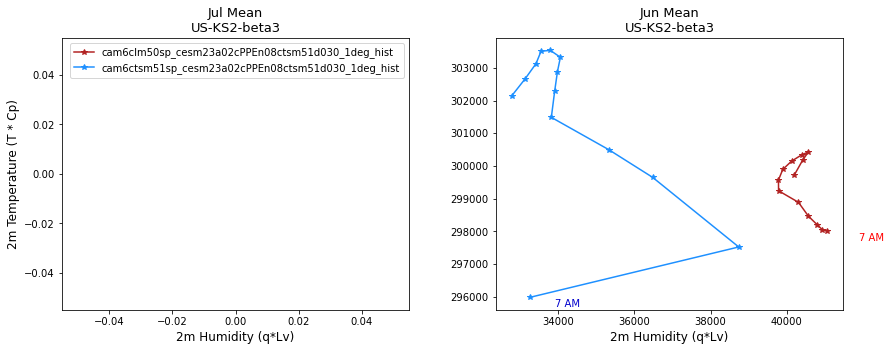

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


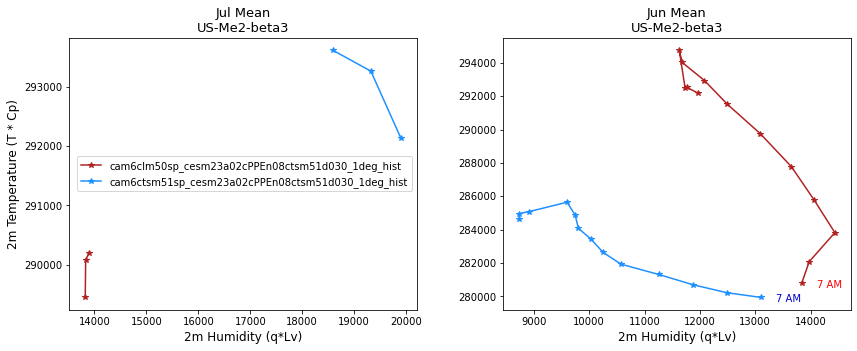

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


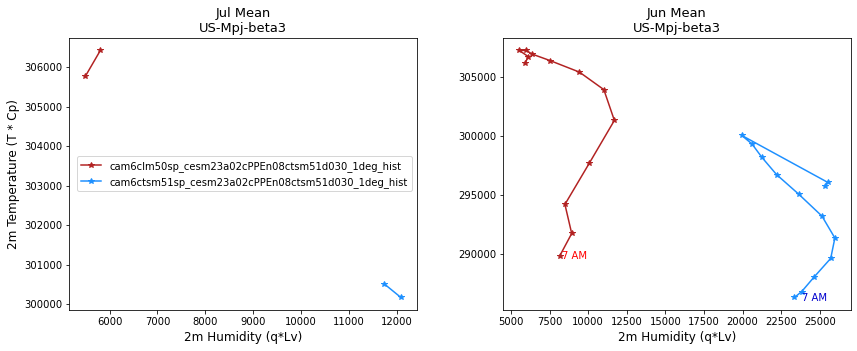

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


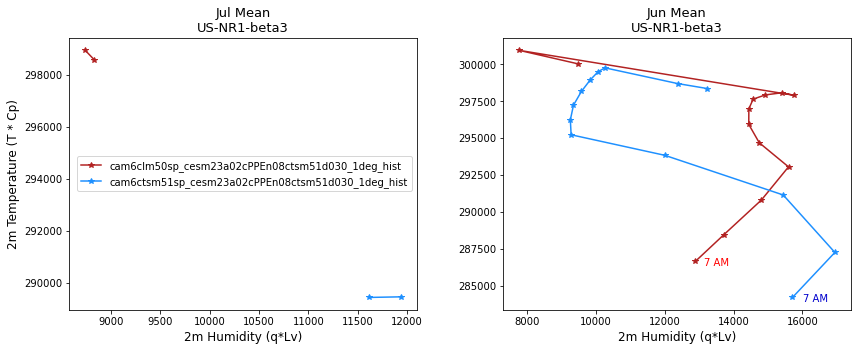

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


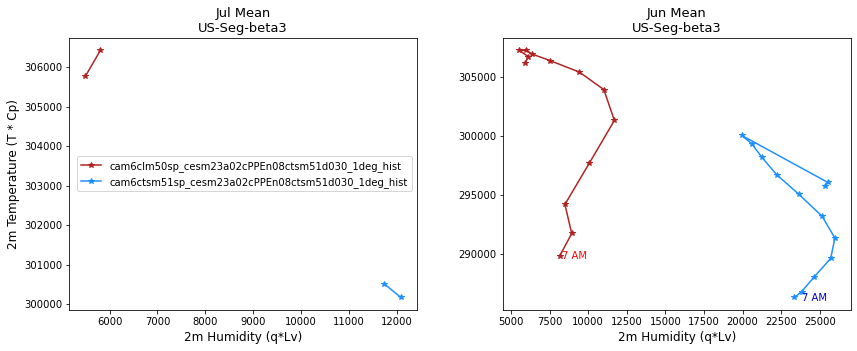

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


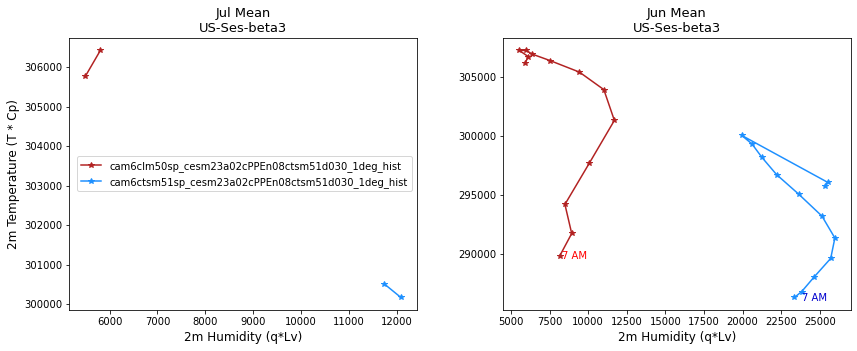

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


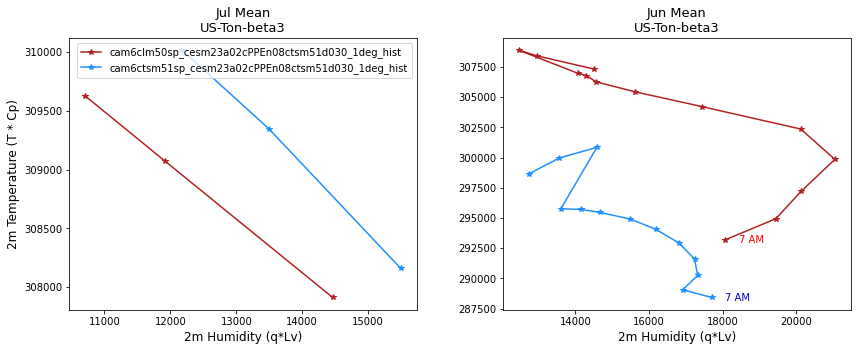

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


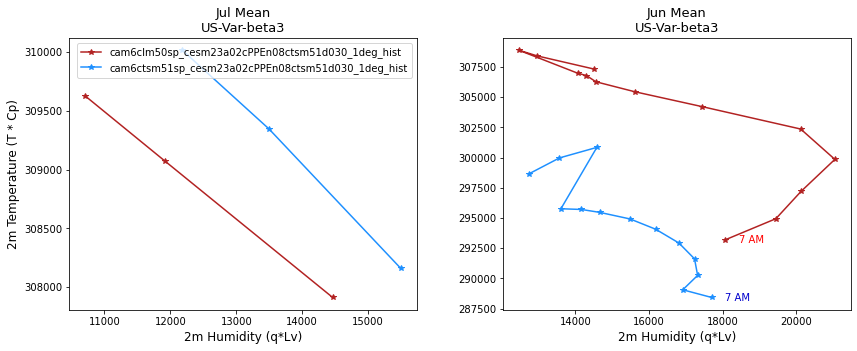

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


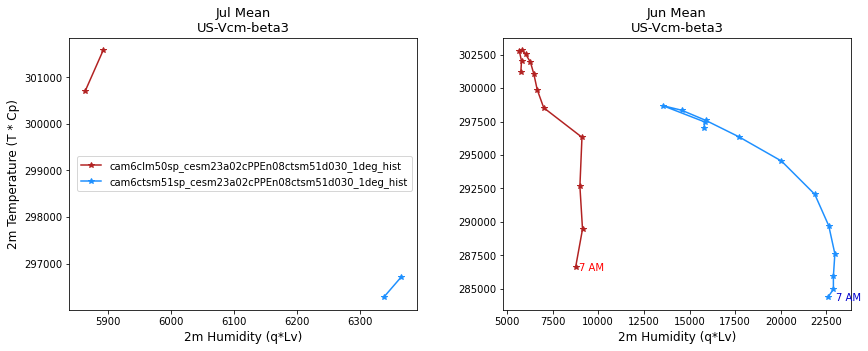

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


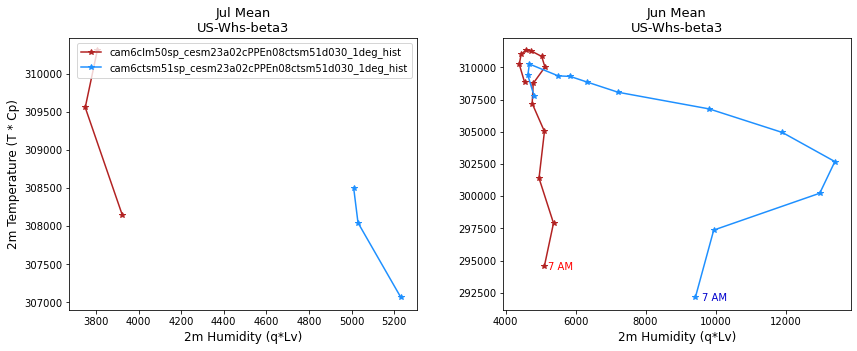

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


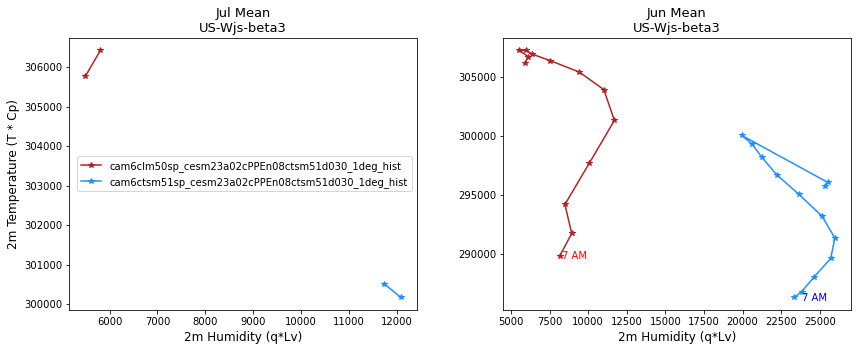

In [31]:
## Set up figure per station 

# Define some constants/useful arrays
nMonths = len(stationDS_full_case1.monthhour_level_0.values)
monthNames = np.asarray(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
Lv = 2.5e6      # Latent heat of vaporization
Cp = 1005.7     # Specific heat capacity 
     
for iStation in range(nStations):
    # Set up figure 
    fig, axs = plt.subplots(1,nMonths, figsize=(14, 5), 
                        facecolor='w', edgecolor='k')
    axs = axs.ravel()
    fig.subplots_adjust(wspace = 0.25)

    for iMonth in range(nMonths):
        
        # Plot 2m Temperature as a function of 2m Humidity (in energy units)

        axs[iMonth].plot(stationDS_full_case1.QREFHT.values[iStation,iMonth,:]*Lv,
                           stationDS_full_case1.TREFHT.values[iStation,iMonth,:]*Cp,
                           '*-',color='firebrick', label = case1)
        
        axs[iMonth].plot(stationDS_full_case2.QREFHT.values[iStation,iMonth,:]*Lv,
                           stationDS_full_case2.TREFHT.values[iStation,iMonth,:]*Cp,
                           '*-',color='dodgerblue', label = case2)
        
        # Label 7a
        axs[iMonth].text(stationDS_full_case1.QREFHT.values[iStation,iMonth,0]*Lv*1.02,
                           stationDS_full_case1.TREFHT.values[iStation,iMonth,0]*Cp*0.999, 
                           '7 AM',color='red', fontsize=10)
        
        axs[iMonth].text(stationDS_full_case2.QREFHT.values[iStation,iMonth,0]*Lv*1.02,
                           stationDS_full_case2.TREFHT.values[iStation,iMonth,0]*Cp*0.999, 
                           '7 AM',color='mediumblue', fontsize=10)
        
        # Set titles/labels 
        axs[iMonth].set_title(monthNames[stationDS_full_case1.monthhour_level_0.values[iMonth-1]]+' Mean\n'+stationNames[iStation],fontsize=13)
        axs[iMonth].set_xlabel('2m Humidity (q*Lv)',fontsize=12)
        if iMonth==0:
            axs[iMonth].set_ylabel('2m Temperature (T * Cp)', fontsize=12)
            axs[iMonth].legend()
                

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

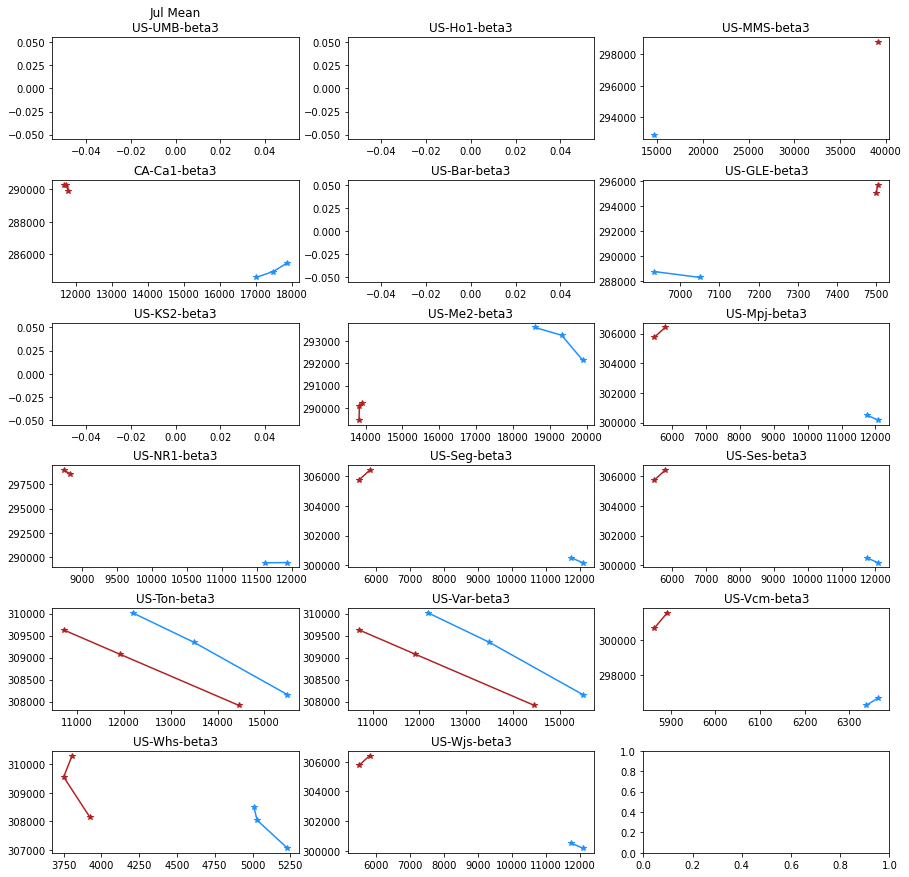

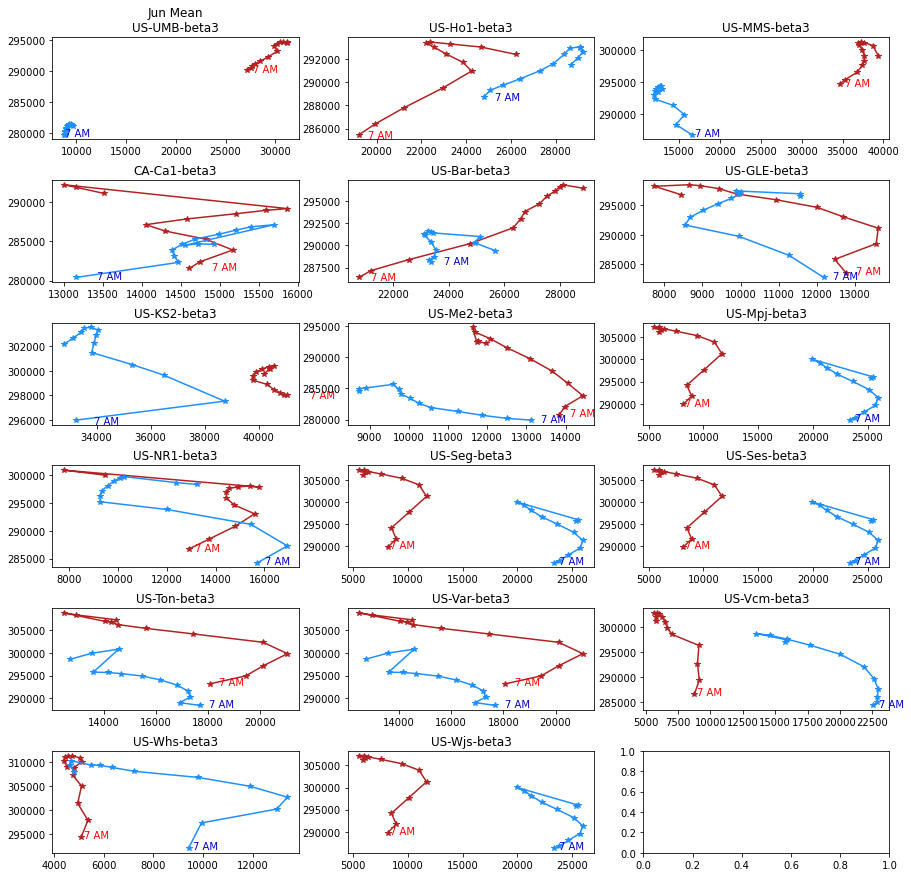

In [17]:
## Set up figure per month 

# Define some constants/useful arrays
nMonths = len(stationDS_full_case1.monthhour_level_0.values)
monthNames = np.asarray(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
Lv = 2.5e6      # Latent heat of vaporization
Cp = 1005.7     # Specific heat capacity 
                            
for iMonth in range(nMonths):
    # Set up figure 
    fig, axs = plt.subplots(6,3, figsize=(15, 15), 
                        facecolor='w', edgecolor='k')
    axs = axs.ravel()
    fig.subplots_adjust(hspace = 0.4)

    for iStation in range(nStations):
        
        # Plot 2m Temperature as a function of 2m Humidity (in energy units)
        
        # T2m_energy = atm_df_selMon_daytime[T2m_name].values * Cp
        # Q2m_energy = atm_df_selMon_daytime[Q2m_name].values * Lv

        axs[iStation].plot(stationDS_full_case1.QREFHT.values[iStation,iMonth,:]*Lv,
                           stationDS_full_case1.TREFHT.values[iStation,iMonth,:]*Cp,
                           '*-',color='firebrick', label = case1)
        
        axs[iStation].plot(stationDS_full_case2.QREFHT.values[iStation,iMonth,:]*Lv,
                           stationDS_full_case2.TREFHT.values[iStation,iMonth,:]*Cp,
                           '*-',color='dodgerblue', label = case2)
        
        # Label 7a
        axs[iStation].text(stationDS_full_case1.QREFHT.values[iStation,iMonth,0]*Lv*1.02,
                           stationDS_full_case1.TREFHT.values[iStation,iMonth,0]*Cp*0.999, 
                           '7 AM',color='red', fontsize=10)
        
        axs[iStation].text(stationDS_full_case2.QREFHT.values[iStation,iMonth,0]*Lv*1.02,
                           stationDS_full_case2.TREFHT.values[iStation,iMonth,0]*Cp*0.999, 
                           '7 AM',color='mediumblue', fontsize=10)
        
        # Set titles/labels 
        if iStation==0:
            axs[iStation].set_title(monthNames[stationDS_full_case1.monthhour_level_0.values[iMonth-1]]+' Mean\n'+stationNames[iStation])
        else: 
             axs[iStation].set_title(stationNames[iStation])
                